In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from keras.applications.vgg16 import VGG16
from keras import backend as K

Using TensorFlow backend.
/data/bitt/wzq/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/bitt/wzq/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/bitt/wzq/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/bitt/wzq

In [2]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
model = VGG16(weights='imagenet')

In [4]:
from keras.preprocessing import image

In [5]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [6]:
img_path = './3.JPEG'

In [7]:
img = image.load_img(img_path, target_size=(224, 224))

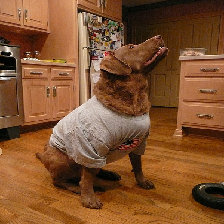

In [8]:
img

In [9]:
x = np.expand_dims(img, axis=0)

In [10]:
x.shape

(1, 224, 224, 3)

In [11]:
x = preprocess_input(x)

In [12]:
x.shape

(1, 224, 224, 3)

In [13]:
preds = model.predict(x)

In [14]:
np.argmax(preds[0])

209

In [15]:
print(preds[0][209])

0.48944038


In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
print(model.output.shape)

(?, 1000)


In [18]:
african_elephant_output = model.output[:, 209]

In [19]:
african_elephant_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [20]:
last_conv_layer = model.get_layer('block5_conv3')

In [21]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

(?, 14, 14, 512)
(512,)


In [22]:
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
# print(conv_layer_output_value)
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# print(conv_layer_output_value.shape)
conv_layer_output_valueb = abs(conv_layer_output_value)
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [23]:
print(heatmap.shape)

(14, 14)


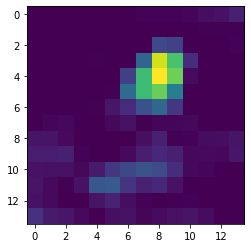

In [24]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [25]:
import cv2

In [26]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

In [27]:
cv2.imwrite('img.jpg', superimposed_img)

True

In [28]:
from PIL import Image

In [29]:
img = Image.open('img.jpg')

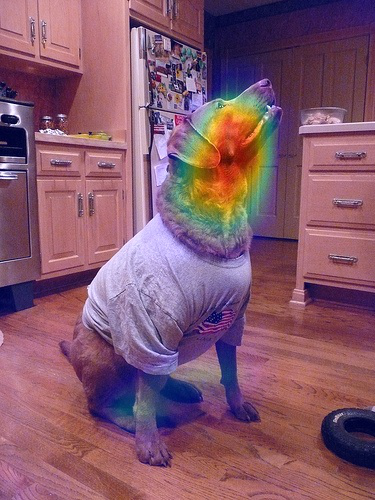

In [30]:
img